## Computer Vision Lab ##

Through these notebooks, we will explore different important techniques, approaches, and uses of deep learning (especially Convolutional Neural Networks) for addressing computer vision labs.

We will explore the following:

- How to create a CNN to classify digits using MNIST dataset
- Use transfer learning concepts to fine-tune pretrained models included in Pytorch
- Different visualization techniques
- Semantic segmentation

### Assignments ###

#### Mandatory: ####

- Compare CNN with an MLP
- Calculate, plot, analyse, and compare different metrics 
    - Loss, Accuracy, Precision, Recall, F1-score (when possible) --> Precision, recall, and F1-score are normally used in binary classification
- Fine-tune pretrained models:
    - by freezing weights
    - reconstructing the layers
- Data augmentation and pre-process
    - For example dataset (bees and ants)
    - For image (mario level)
    
#### Advanced: ####

- Segmentation:
    - Use Mask R-CNN (or other type of network) to do instance segmentation 
- CNN Visualization
    - Apply occlusion to gather heatmap
    - Do either:
        - Visualize through Saliency maps (vanilla backpropagation saliency, or Grad-CAM, or Score-CAM)
        - **OR**
        - Visualize a pre-trained model with Deconvnets
        
#### Optional/if wanted: ####
- Apply CNN to video data 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Dataset (MNIST)

We will use the pytorch dataset and dataloader as seen in the previous lab. We will apply some needed transformation to the data

In [3]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes (0 to 9)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

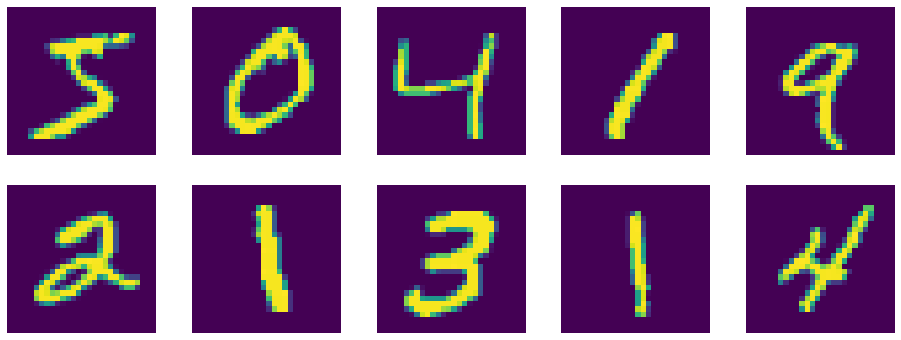

In [4]:
# The MNIST dataset is the handwritten dataset.
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset[i]
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Create the model classes

In [5]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5) # 6 channels and kernel_size 5
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False): # [batch_size, channel, width, height] - [64, 1, 28, 28]
        # First CONV
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) # downdsample the data by half
        
        # Second CONV
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) # downdsample the data by half
        # [64, 6, 4, 4]
        
#         x = x.view(-1, self.n_feature*4*4)
        x = self.flatten(x) # [64, n_feature * 4 * 4]
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x


## Lets go step by step ##

In [6]:
tensor = torch.rand([1, 1, 28, 28]) #Batch size, channel, width, height (what the network expect)
print(tensor.shape)

torch.Size([1, 1, 28, 28])


In [7]:
conv_1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
relu_1 = F.relu
max_pool_1 = nn.MaxPool2d(kernel_size=2)

result = conv_1(tensor)
print("after conv1: ", result.shape) 
#Tensor is reshaped from [1, 1, 28, 28] to [1, 6, 24, 24]
# 6 are the number of out_channels specified
# and it reduces w and h to 24, 24 because of the kernel_size (kernel_size - 1) and stride (stride = 1)

result = relu_1(result)
print("after relu1: ", result.shape)

result = max_pool_1(result)
print("after max_pooling_1: ", result.shape) 
# tensor is reshaped from [1, 6, 24, 24] to [1, 6, 12, 12]
# max pooling downsamples dividing by kernel_size

after conv1:  torch.Size([1, 6, 24, 24])
after relu1:  torch.Size([1, 6, 24, 24])
after max_pooling_1:  torch.Size([1, 6, 12, 12])


In [8]:
conv_2 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=5)
relu_2 = F.relu
max_pool_2 = nn.MaxPool2d(kernel_size=2)

result = conv_2(result)
print("after conv2: ", result.shape)

result = relu_2(result)
print("after relu2: ", result.shape)

result = max_pool_2(result)
print("after max_pooling_2: ", result.shape)
print("shape is [1, 6*4*4]: ", 6*4*4)

after conv2:  torch.Size([1, 6, 8, 8])
after relu2:  torch.Size([1, 6, 8, 8])
after max_pooling_2:  torch.Size([1, 6, 4, 4])
shape is [1, 6*4*4]:  96


In [9]:
flatten_operation = nn.Flatten()

result_flattened = flatten_operation(result)
print("after flattening: ", result_flattened.shape)

result_with_view = result.view(-1, 6*4*4)
print("after view: ", result_with_view.shape)

after flattening:  torch.Size([1, 96])
after view:  torch.Size([1, 96])


## Train and Test loop

In [10]:
def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device) # [64, 1, 28, 28]
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        #if batch_idx % 100 == 0:
        #    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #       epoch, batch_idx * len(data), len(train_loader.dataset),
        #       100. * batch_idx / len(train_loader), loss.item()))

In [11]:
accuracy_list = []
loss_list = []

def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    loss_list.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a ConvNet with the same number of parameters

In [12]:
# Training settings 
n_features = 10 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
print(model_cnn)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)))

for epoch in range(0, 5):
    train(epoch, model_cnn)
    test(model_cnn)
Acc_CNN_list = accuracy_list
Loss_CNN_list = loss_list


CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=160, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
Number of parameters: 11330

Test set: Average loss: 0.1699, Accuracy: 9451/10000 (95%)


Test set: Average loss: 0.0803, Accuracy: 9741/10000 (97%)


Test set: Average loss: 0.0642, Accuracy: 9799/10000 (98%)


Test set: Average loss: 0.0758, Accuracy: 9767/10000 (98%)


Test set: Average loss: 0.0484, Accuracy: 9839/10000 (98%)



# Create and Train a small fully-connected network on the same task

Compare and plot as well for it!

In [13]:
#Creating and training a MLP

class MLP(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten() # Used to convert the 2D input into 1D (28x28 to 784)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, output_size),
            nn.ReLU()
        )
        #self.softmax = F.log_softmax(dim=1) # y = [2.5, 0.9, 0.2] -> softmax(y) -> [0.768, 0.155, 0.077] (if you want to test https://keisan.casio.com/exec/system/15168444286206)
        #self.softmax_result = 0

    def forward(self, x): 
        x = self.flatten(x) #[64, 28, 28] -> [64, 784] [batch size, width, height]
        x = self.linear_relu_stack(x)
        #self.softmax_result
        x= F.log_softmax(x, dim=1)
        return x
    
    
#Training

n_feature = 10
accuracy_list=[]
loss_list=[]
model_MLP = MLP(input_size, n_features, output_size)
print(model_MLP)
model_MLP.to(device)
optimizer = optim.SGD(model_MLP.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(sum(p.numel() for p in model_MLP.parameters() if p.requires_grad)))

for epoch in range(0, 5):
    train(epoch, model_MLP)
    test(model_MLP)
Acc_MLP_list = accuracy_list
Loss_MLP_list = loss_list

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
    (3): ReLU()
  )
)
Number of parameters: 407050

Test set: Average loss: 0.2546, Accuracy: 9267/10000 (93%)


Test set: Average loss: 0.1931, Accuracy: 9428/10000 (94%)


Test set: Average loss: 0.1568, Accuracy: 9537/10000 (95%)


Test set: Average loss: 0.1342, Accuracy: 9609/10000 (96%)


Test set: Average loss: 0.1185, Accuracy: 9646/10000 (96%)



## PLOT Loss, Accuracy, and compare! ##

[94.51, 97.41, 97.99, 97.67, 98.39]
[92.67, 94.28, 95.37, 96.09, 96.46]
[0.16987476348876954, 0.08034547271728516, 0.06421411933898925, 0.07582760200500488, 0.04838300895690918]
[0.25462481994628905, 0.1930619369506836, 0.15679341583251954, 0.13424081268310548, 0.11850258865356446]


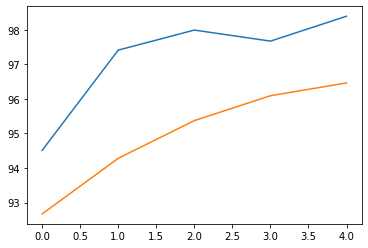

In [14]:
print(Acc_CNN_list)
print(Acc_MLP_list)
print(Loss_CNN_list)
print(Loss_MLP_list)
fig, ax = plt.subplots()
ax.plot(Acc_CNN_list,color='tab:blue')
ax.plot(Acc_MLP_list,color='tab:orange')

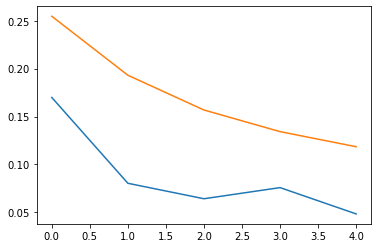

In [15]:
fig, ax = plt.subplots()
ax.plot(Loss_CNN_list,color='tab:blue')
ax.plot(Loss_MLP_list,color='tab:orange')

## Experiment ##

### What happens when the data (imgs) does not make sense anymore - all assumptions are removed ###

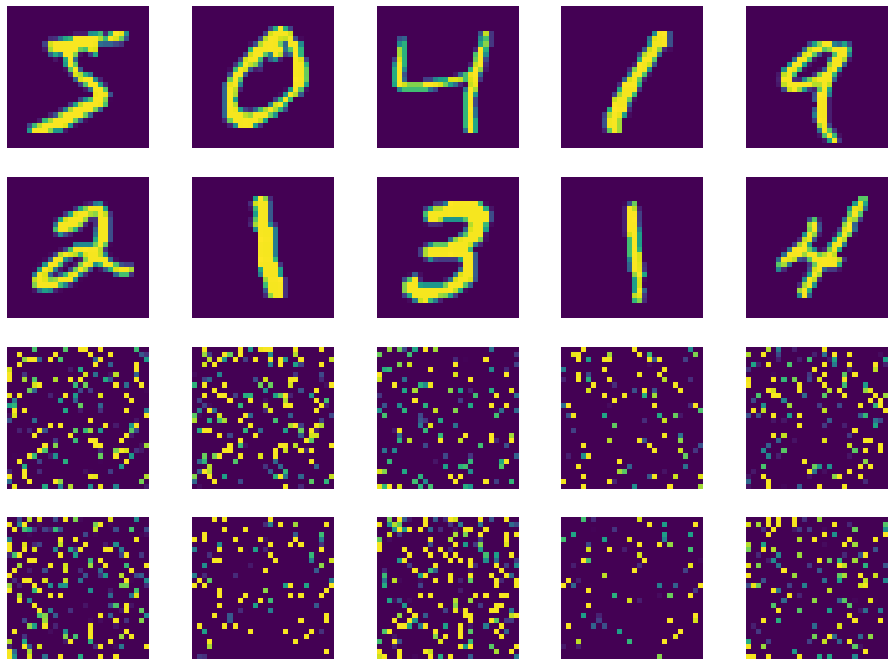

In [16]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset[i]
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

In [20]:
# Training settings 
n_features = 10 # number of feature maps
accuracy_list = []
loss_list = []
model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)

for epoch in range(0, 5):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)
Acc_CNN_list2 = accuracy_list
Loss_CNN_list2 = loss_list


Test set: Average loss: 0.4783, Accuracy: 8523/10000 (85%)


Test set: Average loss: 0.3119, Accuracy: 9069/10000 (91%)


Test set: Average loss: 0.2761, Accuracy: 9154/10000 (92%)


Test set: Average loss: 0.2397, Accuracy: 9271/10000 (93%)


Test set: Average loss: 0.2438, Accuracy: 9266/10000 (93%)



## Do the same with the MLP ##

In [21]:
# create network, train, compare!
n_feature = 10
accuracy_list=[]
loss_list=[]
model_MLP2 = MLP(input_size, n_features, output_size)
model_MLP2.to(device)
optimizer = optim.SGD(model_MLP2.parameters(), lr=0.01, momentum=0.5)

for epoch in range(0, 5):
    train(epoch, model_MLP2, perm)
    test(model_MLP2, perm)
Acc_MLP_list2 = accuracy_list
Loss_MLP_list2 = loss_list


Test set: Average loss: 0.2544, Accuracy: 9292/10000 (93%)


Test set: Average loss: 0.1953, Accuracy: 9446/10000 (94%)


Test set: Average loss: 0.1597, Accuracy: 9535/10000 (95%)


Test set: Average loss: 0.1346, Accuracy: 9607/10000 (96%)


Test set: Average loss: 0.1187, Accuracy: 9659/10000 (97%)



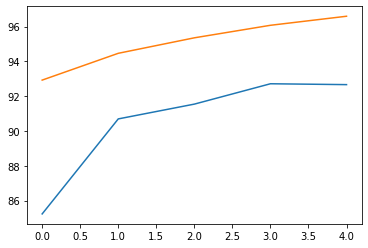

In [22]:
fig, ax = plt.subplots()
ax.plot(Acc_CNN_list2,color='tab:blue')
ax.plot(Acc_MLP_list2,color='tab:orange')

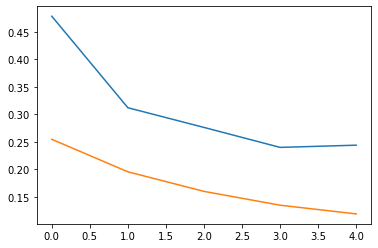

In [25]:
fig, ax = plt.subplots()
ax.plot(Loss_CNN_list2,color='tab:blue')
ax.plot(Loss_MLP_list2,color='tab:orange')

## What to do next? ##

- Change the task
- upload your handwriten work.
- Fine-tune the network so it learn your handwritting?